In [1]:
from lightglue import LightGlue, SIFT, viz2d
from lightglue.utils import load_image, rbd
import torch
import numpy as np
from scipy.stats import wasserstein_distance # Will need this if we use wasserstein
import re
import time
import pickle
import pandas as pd
import random

from pathlib import Path

In [2]:
torch.set_grad_enabled(False)

In [3]:
# Use GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

In [4]:
def load_split(size: str = "nano") -> pd.DataFrame:
    split_filepath = Path(f"../../../data/04_feature/bearidentification/bearid/split/by_individual/{size}/data_split.csv")
    return pd.read_csv(split_filepath, sep=";")

def draw_triplet_from(df: pd.DataFrame, random_seed: int = 42) -> dict[str, Path]:
    random.seed(random_seed)
    bear_ids = set(df.bear_id.unique().tolist())
    anchor_bear_id = random.choice(list(bear_ids))
    bear_ids_without_anchor_bear_id = bear_ids - set([anchor_bear_id])
    negative_bear_id = random.choice(list(bear_ids_without_anchor_bear_id))

    df_pos = df[df["bear_id"] == anchor_bear_id]
    df_neg = df[df["bear_id"] == negative_bear_id]

    df_pos_sample = df_pos.sample(n=2, random_state=random_seed)
    anchor_path, positive_path = df_pos_sample.iloc[0]["path"], df_pos_sample.iloc[1]["path"]

    df_neg_sample = df_neg.sample(n=1, random_state=random_seed)
    negative_path =  df_neg_sample.iloc[0]["path"]


    return {
        "anchor": anchor_path, 
        "positive": positive_path, 
        "negative": negative_path,
    }

In [5]:
def visualize_matching(path0: Path, path1: Path, features_dict: dict, matcher) -> None:
    image0 = load_image(Path("../../../") / path0)
    image1 = load_image(Path("../../../") / path1)
    
    feats0 = features_dict[path0]
    feats1 = features_dict[path1]
    
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension

    matches = matches01['matches']  # indices with shape (K,2)
    points0 = feats0['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
    points1 = feats1['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)

    axes = viz2d.plot_images([image0, image1])
    viz2d.plot_matches(points0, points1, color="lime", lw=0.2)
    viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)


def visualize_triplet(anchor_path: Path, positive_path: Path, negative_path: Path, features_dict: dict, matcher) -> None:
    anchor_image = load_image(Path("../../../") / anchor_path)
    positive_image = load_image(Path("../../../") / positive_path)
    negative_image = load_image(Path("../../../") / negative_path)
    
    viz2d.plot_images([anchor_image, positive_image, negative_image], titles=["anchor", "positive", "negative"])

    visualize_matching(anchor_path, positive_path, features_dict, matcher)
    visualize_matching(anchor_path, negative_path, features_dict, matcher)


def load(extractor_type: str = "sift", n_keypoints: int = 1024) -> dict:
    features_filepath = Path(f"../../../data/04_feature/bearidentification/lightglue/8a505e53d07ef04bda85260ece34238d/{extractor_type}/{n_keypoints}/features.pth")
    features_dict = torch.load(features_filepath)
    matcher = LightGlue(features='sift').eval()
    return {"features_dict": features_dict, "matcher": matcher}

In [6]:
extractor_type = "sift"
sift_data = load(extractor_type=extractor_type)
matcher = sift_data["matcher"]
features_dict = sift_data["features_dict"]

In [7]:
df_split = load_split()
df_split.head()

,origin,encounter,bear_id,image,path,split
0,brooksFalls,je_201708,bf_480,480-otis_14592316682_o.jpg,data/07_model_output/bearfacesegmentation/chip...,train
1,brooksFalls,je_201708,bf_480,480-otis_10234355613_o.jpg,data/07_model_output/bearfacesegmentation/chip...,train
2,brooksFalls,je_201708,bf_480,480-otis_9382835168_o.jpg,data/07_model_output/bearfacesegmentation/chip...,train
3,brooksFalls,je_201708,bf_480,480-otis-in-far-pool_11332560345_o.jpg,data/07_model_output/bearfacesegmentation/chip...,train
4,brooksFalls,je_201708,bf_480,480-otis_10234289115_o.jpg,data/07_model_output/bearfacesegmentation/chip...,train


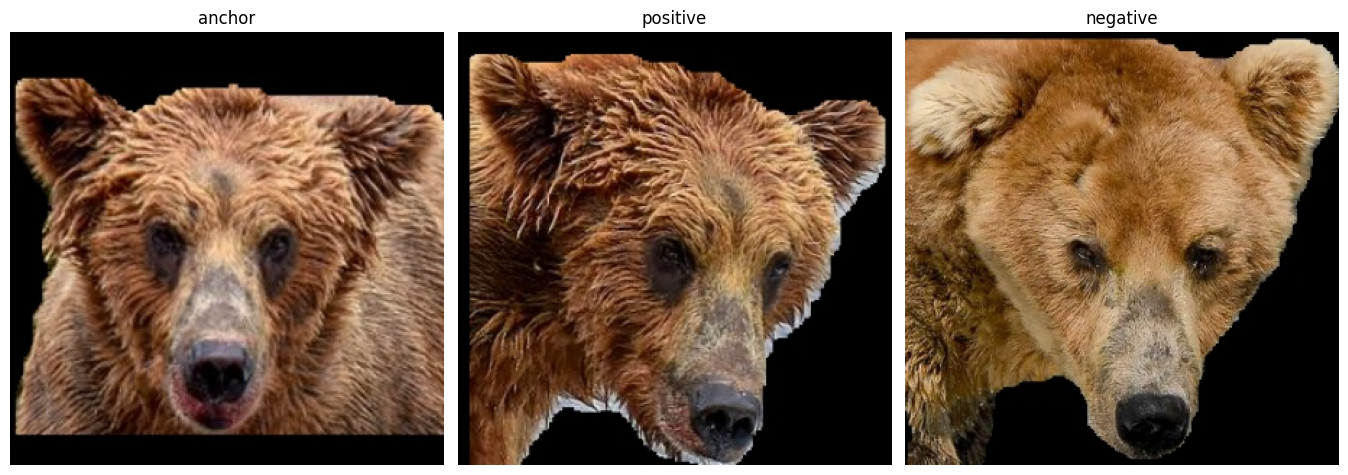

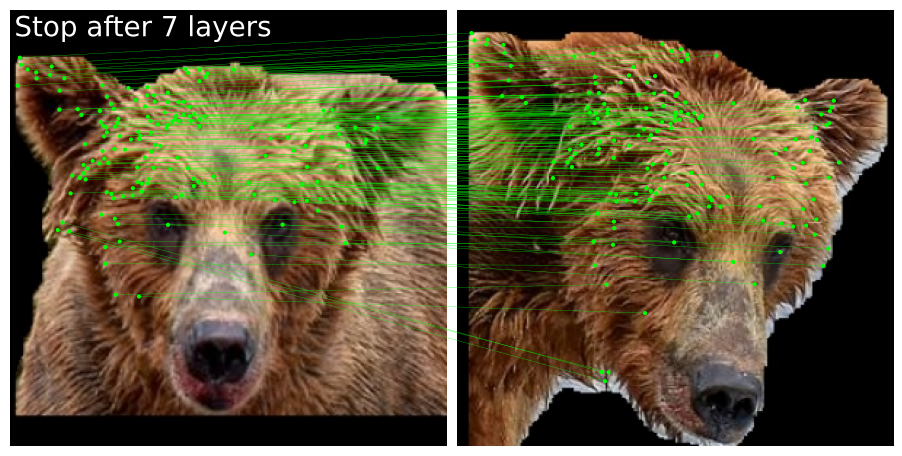

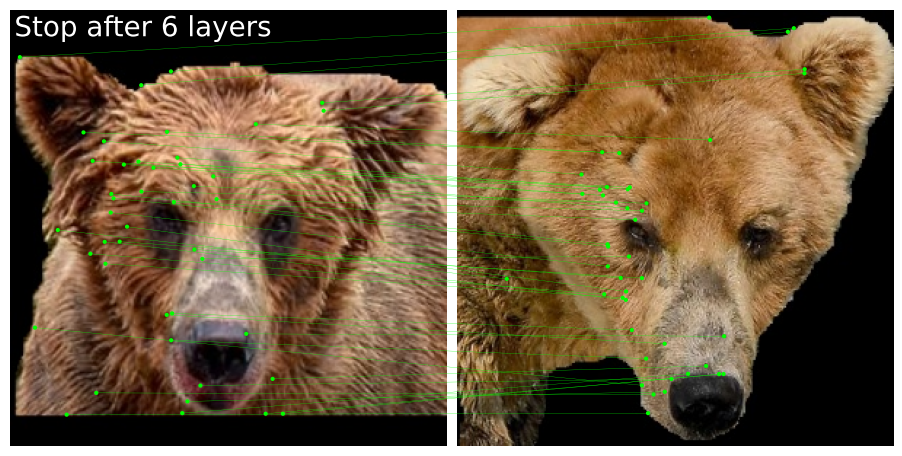

In [8]:
triplet = draw_triplet_from(df_split)
anchor_path, positive_path, negative_path = triplet["anchor"], triplet["positive"], triplet["negative"]
visualize_triplet(anchor_path=anchor_path, positive_path=positive_path, negative_path=negative_path, features_dict=features_dict, matcher=matcher)